## Camera Calibration using OpenCV

Reference: https://docs.opencv.org/3.4.15/dc/dbb/tutorial_py_calibration.html

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
# downloading data using OpenCV
!git clone https://github.com/opencv/opencv.git

fatal: destination path 'opencv' already exists and is not an empty directory.


In [3]:
# images path
path = 'opencv/samples/data/'
images_path = [path + 'left' + '%.2d.jpg' % i for i in (list(range(1,10)) + list(range(11,15)))]
print('Number of images:', len(images_path))
print('Sample Image: ', images_path[0])

Number of images: 13
Sample Image:  opencv/samples/data/left01.jpg


## Finding Chessboard Corners

1. To find pattern in chess board, we use cv.findChessboardCorners(). 
2. This function may not be able to find the required pattern in all the images. 
3. Once we find the corners, we can increase their accuracy using cv.cornerSubPix().

In [4]:
import numpy as np
import cv2 as cv
import glob

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

objp[:5]

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.]], dtype=float32)

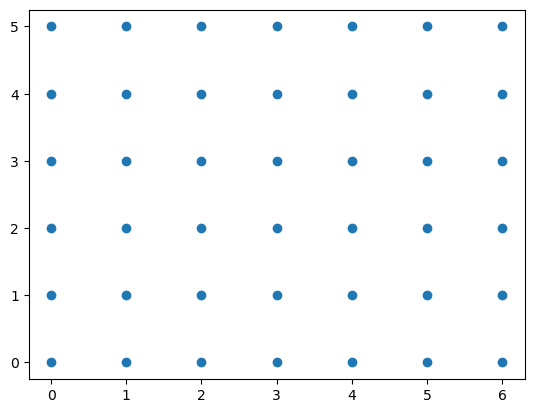

In [5]:
# object points
plt.scatter(objp[:,0], objp[:,1])
plt.show()

True


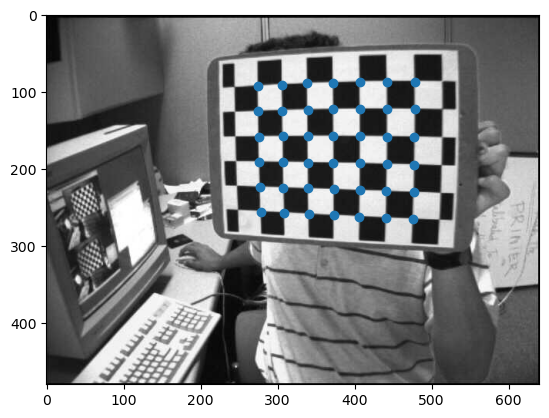

In [6]:
fname = images_path[0]
img = cv.imread(fname)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# finding Chessboard Corners
ret, corners = cv.findChessboardCorners(gray, (7,6), None)
print(ret)

corners1 = corners.reshape(len(corners),-1)

plt.imshow(img)
plt.scatter(corners1[:,0], corners1[:,1])
plt.show()

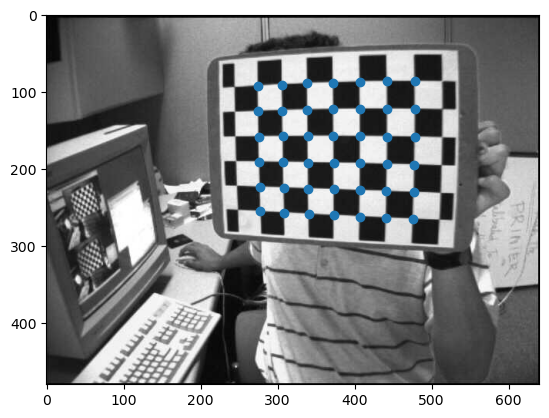

In [7]:
# increasing accuracy by cv.cornerSubPix
corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
corners2 = corners2.reshape(len(corners2),-1)

plt.imshow(img)
plt.scatter(corners2[:,0], corners2[:,1])
plt.show()

### Understanding Distortion

Let's look at the orientation of object and image points. 

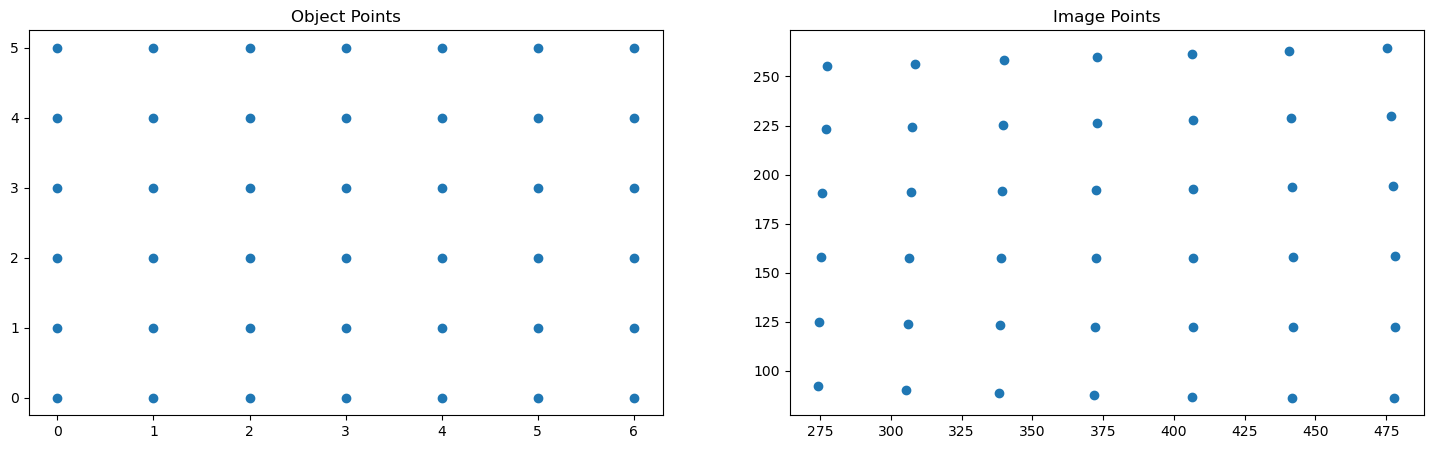

In [8]:
plt.figure(figsize=(18,5))

plt.subplot(121)
plt.title('Object Points')
plt.scatter(objp[:,0], objp[:,1])

plt.subplot(122)
plt.title('Image Points')
plt.scatter(corners2[:,0], corners2[:,1])
plt.show()

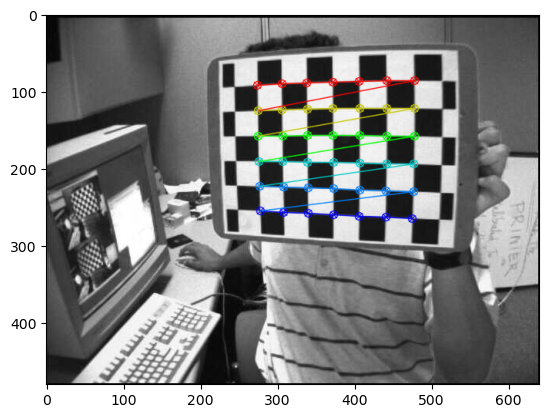

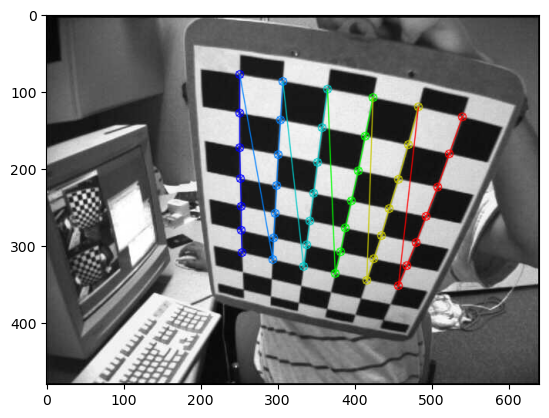

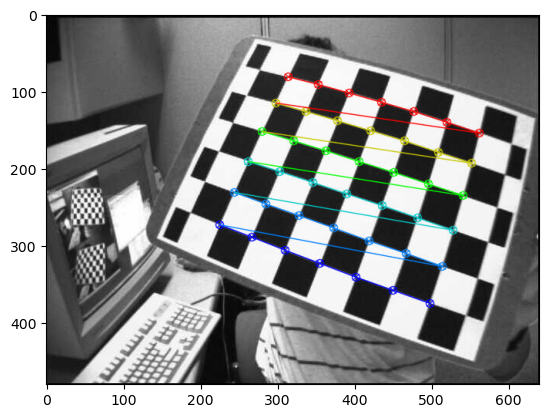

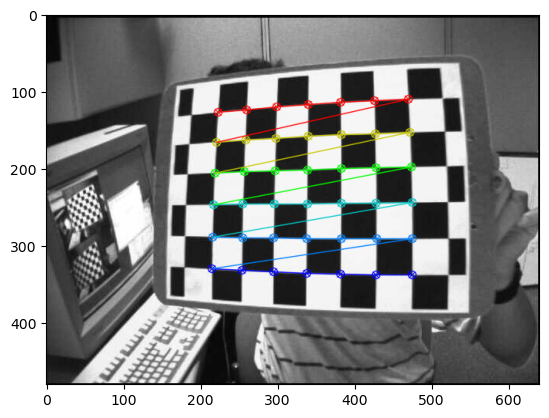

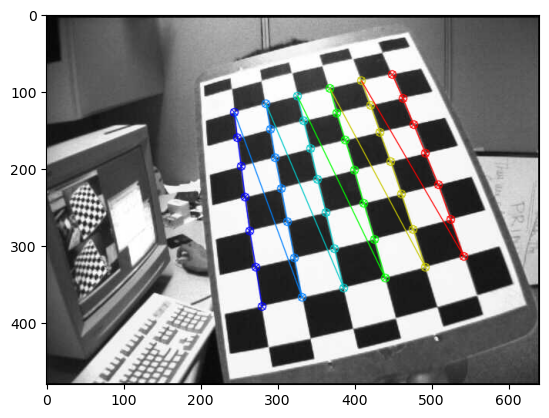

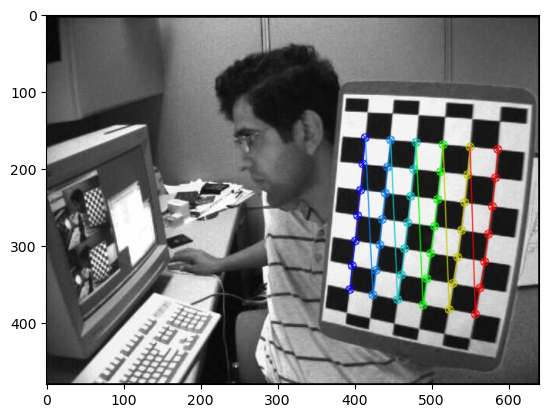

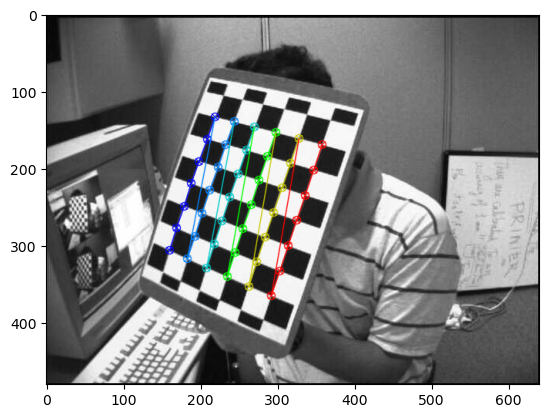

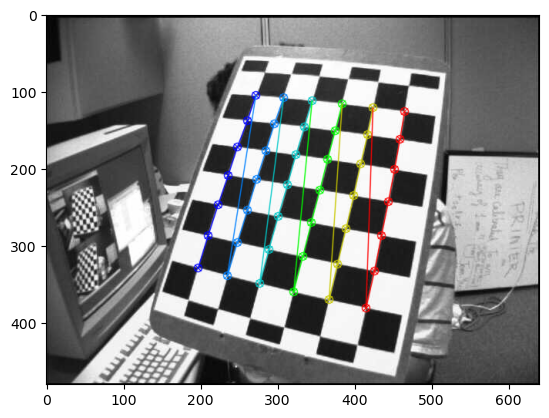

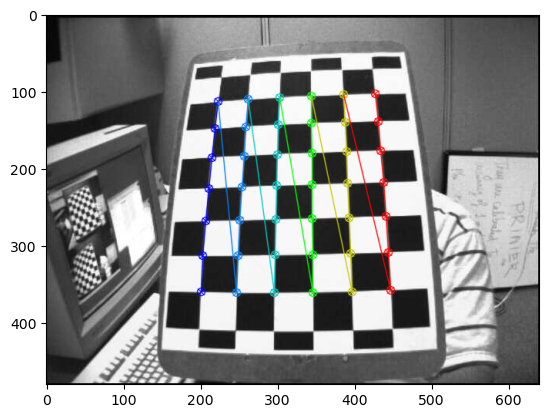

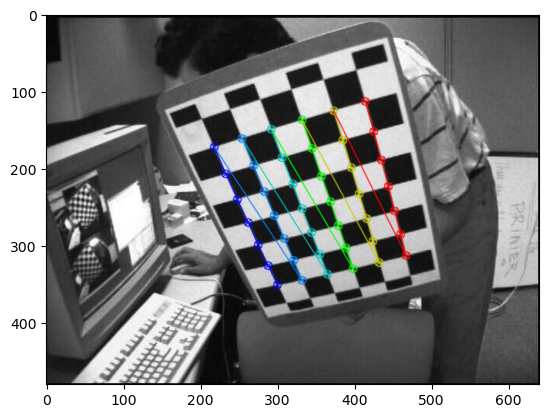

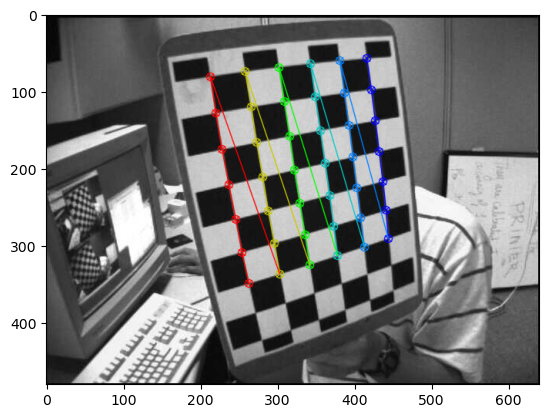

In [9]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = images_path
chessboard_found_images = []
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        chessboard_found_images.append(fname)
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()
#         cv.imshow('img', img)
#         cv.waitKey(500)
        
# cv.destroyAllWindows()

In [10]:
objpoints[0].shape, objpoints[0][:2]

((42, 3),
 array([[0., 0., 0.],
        [1., 0., 0.]], dtype=float32))

In [11]:
imgpoints[0].shape, imgpoints[0][:2]

((42, 1, 2),
 array([[[475.32184, 264.62466]],
 
        [[440.50244, 263.23285]]], dtype=float32))

### Camera Calibration

The steps are as follows:

1. Finding the parameters:
    1. Distortion parameters - (5 in total)
    2. Intrinsic parameters - parameters specific to camera - focal length, optical centers - (4 in total)
    3. Extrinsic parameters - rotational and translational vectors - (3 + 3 in total)
2. Calculating the reprojection error under different settings to find the best set of parameters
3. Undistorting the images

In [12]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [13]:
# overall RMS re-projection error
ret

0.1553690201596675

In [14]:
# intrinsic parameters - parameters specific to camera
# focal length and optical center

# camera matrix
mtx

array([[534.07088323,   0.        , 341.53407616],
       [  0.        , 534.11914507, 232.94565306],
       [  0.        ,   0.        ,   1.        ]])

In [15]:
# distortion parameters
dist

array([[-2.92971624e-01,  1.07706900e-01,  1.31038424e-03,
        -3.11033866e-05,  4.34799406e-02]])

In [16]:
# extrinsic parameters
# rotational and translational vectors - one for each image
len(rvecs), len(tvecs)

(11, 11)

## Re-projection Error

Re-projection error gives a good estimation of just how exact the found parameters are. The closer the re-projection error is to zero, the more accurate the parameters we found are. 

Given the intrinsic, distortion, rotation and translation matrices, we can calculate the error using projecting points and computing norm. 

In [17]:
def calculate_reprojection_error(objpoints, mtx, dist, rvecs, tvecs):

    mean_error = 0

    for i in range(len(objpoints)):
        imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
        mean_error += error

    print( "total error: {}".format(mean_error/len(objpoints)) )
    
    return mean_error/len(objpoints)

## Undistortion

**We will look at different settings to compute camera matrix and calculate reprojection error in all cases. We will go ahead with the one with the least error.**

Settings:
1. Original Camera Matrix
2. Refined camera matrix:
    1. Scaling Parameter - 0
    2. Scaling Parameter - 1
3. Remapping

In [18]:
chessboard_found_images

['opencv/samples/data/left01.jpg',
 'opencv/samples/data/left02.jpg',
 'opencv/samples/data/left03.jpg',
 'opencv/samples/data/left04.jpg',
 'opencv/samples/data/left05.jpg',
 'opencv/samples/data/left06.jpg',
 'opencv/samples/data/left07.jpg',
 'opencv/samples/data/left08.jpg',
 'opencv/samples/data/left12.jpg',
 'opencv/samples/data/left13.jpg',
 'opencv/samples/data/left14.jpg']

In [19]:
test_image = 'opencv/samples/data/left09.jpg'
test_image

'opencv/samples/data/left09.jpg'

### Method 1 - Original Camera Matrix

Using cv.undistort()

total error: 0.023685996975391924


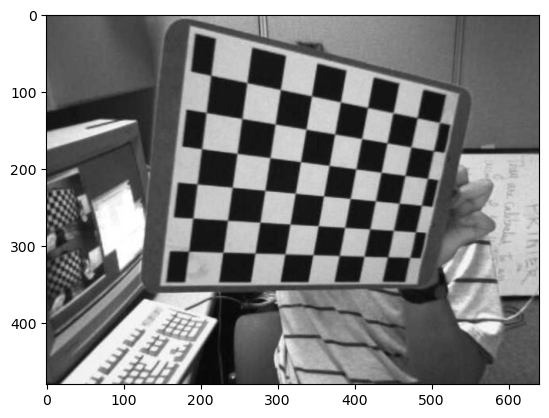

In [20]:
# original camera matrix
# undistort

img = cv.imread(test_image)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
h, w = img.shape[:2]

# calculating error
err1 = calculate_reprojection_error(objpoints, mtx, dist, rvecs, tvecs)

# undistorting image
dst = cv.undistort(img, mtx, dist, None, None)
cv.imwrite('results/result_orig_mtx.png', cv.cvtColor(dst, cv.COLOR_RGB2BGR))

plt.figure()
plt.imshow(dst)
plt.show()

### Method 2 - Refined Camera Matrix

Scaling Parameter - 0

total error: 1.7176850912912498


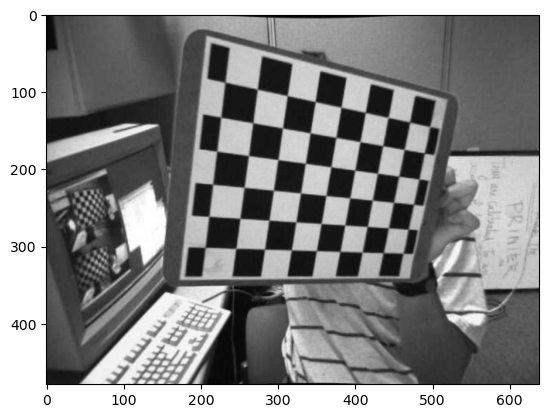

In [21]:
# refine camera matrix
# scaling parameter - 0 
newcameramtx1, roi1 = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))

err2 = calculate_reprojection_error(objpoints, newcameramtx1, dist, rvecs, tvecs)

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx1)

# crop the image
x, y, w, h = roi1

dst = dst[y:y+h, x:x+w]
cv.imwrite('results/refine_alpha_0.png', cv.cvtColor(dst, cv.COLOR_RGB2BGR))

plt.figure()
plt.imshow(dst)
plt.show()

### Method 2 - Refined Camera Matrix

Scaling Parameter - 1

total error: 2.6878124180520513


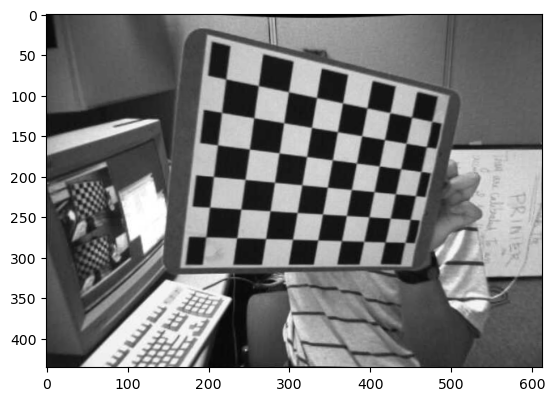

In [22]:
# refine camera matrix
# scaling parameter - 1 
newcameramtx2, roi2 = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

err3 = calculate_reprojection_error(objpoints, newcameramtx2, dist, rvecs, tvecs)

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx2)

# crop the image
x, y, w, h = roi2

dst = dst[y:y+h, x:x+w]

os.makedirs('results', exist_ok=True)
cv.imwrite('results/refine_alpha_1.png', cv.cvtColor(dst, cv.COLOR_RGB2BGR))

plt.figure()
plt.imshow(dst)
plt.show()

### Method 3 - Remapping

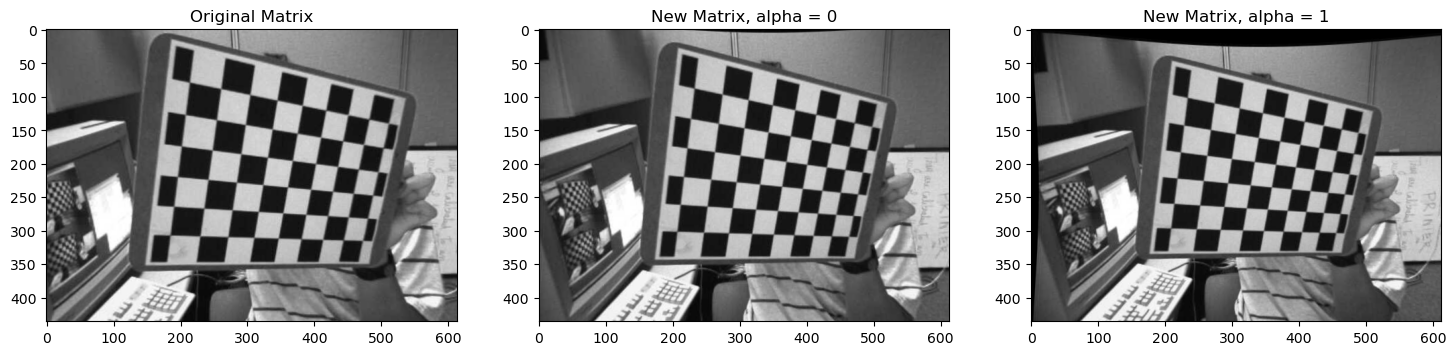

In [23]:
# undistort
plt.figure(figsize=(18,5))

plt.subplot(131)
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, mtx, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
cv.imwrite('results/remap_originalmtx.png', cv.cvtColor(dst, cv.COLOR_RGB2BGR))
plt.title('Original Matrix')
plt.imshow(dst)

plt.subplot(132)
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx1, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
cv.imwrite('results/remap_newmtx1.png', cv.cvtColor(dst, cv.COLOR_RGB2BGR))
plt.title('New Matrix, alpha = 0')
plt.imshow(dst)

plt.subplot(133)
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx2, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
cv.imwrite('results/remap_newmtx2.png', cv.cvtColor(dst, cv.COLOR_RGB2BGR))
plt.title('New Matrix, alpha = 1')
plt.imshow(dst)

plt.show()

In [24]:
errors = {}
errors['original'] = err1
errors['scaling_alpha_0'] = err2
errors['scaling_alpha_1'] = err3

errors

{'original': 0.023685996975391924,
 'scaling_alpha_0': 1.7176850912912498,
 'scaling_alpha_1': 2.6878124180520513}

Now you can store the camera matrix and distortion coefficients using write functions in NumPy (np.savez, np.savetxt etc) for future uses.

In [25]:
# saving parameters
np.savez('params.npz', ret = ret, mtx = mtx, dist = dist, rvecs = rvecs, tvecs = tvecs)

# loading parameters
np.load('params.npz').files

['ret', 'mtx', 'dist', 'rvecs', 'tvecs']